

# 1. Import all needed libraries

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import pandas as pd
from collections import namedtuple

import gym
import random
import itertools
import sys
from collections import defaultdict
from gym.envs.toy_text.cliffwalking import CliffWalkingEnv

import time
from IPython.display import clear_output

matplotlib.style.use('ggplot')
%matplotlib inline

# 2. Create an instance of your CliffWalking environment

In [8]:
# Create the Cliffwalking environment
env = gym.make('CliffWalking-v0')
env.render()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



# 3. Define a Plotting Function to avoid the ugly `render()` output

In [9]:
def plot_custom_grid(full_grid, current_position):
    colors = {'C': 'black', '': 'yellow', 'X': 'navy'}

    # Map string values to numeric values
    numeric_grid = np.zeros_like(full_grid, dtype=float)
    for key, value in colors.items():
        numeric_grid[full_grid == key] = 1 if key == 'C' else 0  # Set to 1 for 'C', 0 for '' and 'X'

    fig, ax = plt.subplots(figsize=(10, 5))  # Adjust the size as needed

    # Plotting each cell individually to control borders
    for i in range(full_grid.shape[0]):
        for j in range(full_grid.shape[1]):
            value = full_grid[i, j]
            color = colors.get(value, 'white')  # Default to white if the value is not recognized

            rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1, linewidth=2, edgecolor='black', facecolor=color)
            ax.add_patch(rect)

            ax.text(j, i, value, ha='center', va='center', fontsize=12, color='black' if color == 'white' else 'white')

    ax.set_xlim([-0.5, full_grid.shape[1] - 0.5])
    ax.set_ylim([-0.5, full_grid.shape[0] - 0.5])

    ax.set_xticks(np.arange(full_grid.shape[1]))
    ax.set_yticks(np.arange(full_grid.shape[0]))

    ax.tick_params(axis='both', which='both', length=0)  # Hide tick marks
    ax.xaxis.set_ticks_position('bottom')  # Show ticks on the bottom axis
    ax.yaxis.set_ticks_position('left')    # Show ticks on the left axis

    plt.grid(True, color='black', linewidth=2)  # Add grid lines
    plt.show()

# 4. Give the new plotting function a try

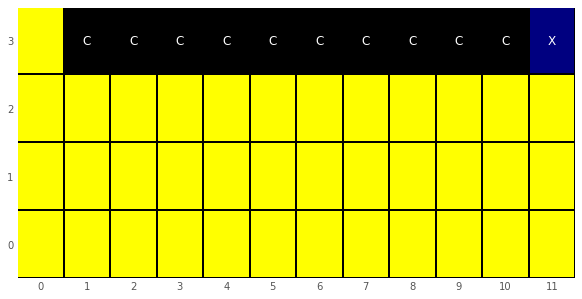

current state (labeled as next) -  47 Is Terminal State? True


In [10]:
env.reset()
actions = [0, 1, 0, 1, 0, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2]
for i in range(len(actions)):
    print("Step Nr.:", i+1, "| Current state:", env.s)
    action = actions[i]
    next_state, reward, is_terminal, t_prob = env.step(action)
    current_position = np.unravel_index(next_state, env.shape)
    print("\nAction taken:", action, "Current Position", current_position)
    
    full_grid = np.full(env.shape, '', dtype='<U1')
    full_grid[3, 1:-1] = 'C'
    full_grid[3, 11] = 'T'
    full_grid[current_position] = 'X'

    plot_custom_grid(full_grid, current_position)
    plt.pause(2)  # Pause for 2 seconds
    clear_output(wait=True)  # Clear the previous output

# Plot final grid and display return values    
plot_custom_grid(full_grid, current_position)    
print("current state (labeled as next) - ", next_state, "Is Terminal State?", is_terminal)

# 5. Define the epsilon-greedy policy and the SARSA algorithm

In [11]:
from collections import namedtuple, defaultdict
import numpy as np
import itertools
import sys

EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])

def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps states to action values.
            Each value is a numpy array of length nA (number of actions).
        epsilon: The probability to select a random action, float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation (state) as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    """
    def policy_fn(state):
        action_probabilities = np.ones(nA, dtype=float) * (epsilon / nA)
        best_action = np.argmax(Q[state])
        action_probabilities[best_action] += (1.0 - epsilon)
        return action_probabilities
    
    return policy_fn

def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    SARSA (State-Action-Reward-State-Action) algorithm: On-policy TD control.
    Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma (γ) discount factor.
        alpha: Step size (α), TD learning rate.
        epsilon: Probability to sample a random action, float between 0 and 1.
    
    Returns:
        A tuple (Q, stats) where Q is the optimal action-value function, 
        a dictionary mapping state -> action values, and stats is an EpisodeStats 
        object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # Initialize the action-value function Q with zeros for all state-action pairs.
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Initialize the state
        state = env.reset()
        
        # Choose action A from state S using policy derived from Q (epsilon-greedy)
        action_probabilities = policy(state)
        action = np.random.choice(np.arange(len(action_probabilities)), p=action_probabilities)
        
        # Loop for each step of the episode
        for t in itertools.count():
            # Take action A, observe R, S'
            next_state, reward, is_terminal, _ = env.step(action)
            
            # Choose A' from S' using policy derived from Q (epsilon-greedy)
            next_action_probabilities = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_action_probabilities)), p=next_action_probabilities)
            
            # Update Q(S,A) := Q(S,A) + α[R + γQ(S',A') - Q(S,A)]
            td_target = reward + discount_factor * Q[next_state][next_action]
            td_error = td_target - Q[state][action]
            Q[state][action] += alpha * td_error

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t

            if is_terminal:
                break
            
            # S ← S'; A ← A'
            state = next_state
            action = next_action

    return Q, stats

# 6. Run the SARSA Algorithm and learn the optimal policy

In [12]:
%%time
Q, stats = sarsa(env, 5000)

CPU times: user 5.56 s, sys: 39.5 ms, total: 5.6 s
Wall time: 5.5 s


# 7. Visualize the results
## Plot 1 - Episode length over time
 - as time passes and iterations advance, we want to see shorter and shorter episodes, which means we get to the terminal state quicker

## Plot 2 - Rewards per episode over time
 - as iterations go, rewards per episode should be close and closer to zero, meaning lesser and lesser negative, which again shows quicker reaching of the terminal state

## Plot 3 - Episodes per Time steps
 - cummulative sum of episode length increasing almost linearly with the number of timesteps, suggests a constant and stable learning

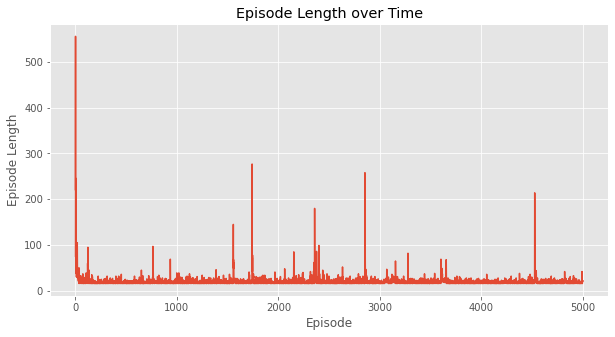

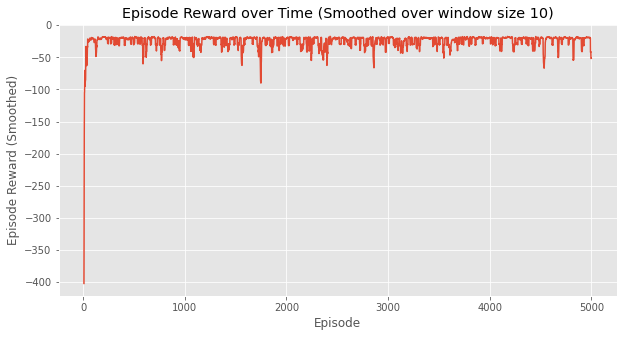

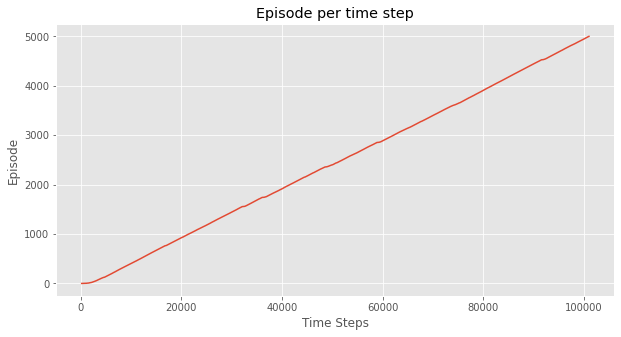

In [13]:
def plot_episode_stats(stats, smoothing_window=10, noshow=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    plt.show(fig2)

    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(10,5))
    plt.plot(np.cumsum(stats.episode_lengths), np.arange(len(stats.episode_lengths)))
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Episode per time step")
    plt.show(fig3)


plot_episode_stats(stats)

# 8. Obtain a greedy policy and a Value function from our Q-table (optimal value-function we learned previously)

In [14]:
# get greedy policy from Q
policy= np.array([np.argmax(Q[key]) if key in Q else -1 for key in np.arange(48)])


# get value function from Q using greedy policy
v = ([np.max(Q[key]) if key in Q else 0 for key in np.arange(48)])

# 9. Gain some insights on the learned Policy and Value Function

In [15]:
action = ["up", "right", "down", "left"]

print("Reshaped Grid Policy:")
actions = np.stack([action for _ in range(len(policy))], axis=0)
print (np.reshape(policy, (4, 12)))
print ("")


print ("Optimal Policy:")
print(np.take(actions, np.reshape(policy, (4, 12))))
print("")

print("Optimal Value Function:")
print(np.reshape(v, (4, 12)))
print("")

Reshaped Grid Policy:
[[ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0  1  0  1  0  1  0  3  0  0  1  2]
 [ 0  3  0  0  0  3  0  0  0  3  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]

Optimal Policy:
[['right' 'right' 'right' 'right' 'right' 'right' 'right' 'right' 'right'
  'right' 'right' 'down']
 ['up' 'right' 'up' 'right' 'up' 'right' 'up' 'left' 'up' 'up' 'right'
  'down']
 ['up' 'left' 'up' 'up' 'up' 'left' 'up' 'up' 'up' 'left' 'right' 'down']
 ['up' 'left' 'left' 'left' 'left' 'left' 'left' 'left' 'left' 'left'
  'left' 'up']]

Optimal Value Function:
[[-15.66955113 -14.63219557 -12.94560599 -12.19847486 -11.51414781
  -10.46892989  -8.71403111  -7.14552138  -6.0515342   -5.22739982
   -5.32329542  -4.13969009]
 [-15.92864002 -16.98810881 -14.88736424 -15.00109394 -12.79579684
  -12.15540206 -11.24087785 -12.11669153  -7.65714368  -8.8839152
   -3.34379664  -3.03268806]
 [-17.10778504 -21.7176057  -16.66883163 -16.49405792 -15.89788471
  -18.48920448 -13.32907054 -14.54423151 -10.0

# 10. Plot the greedy policy using arrows
- Based on the arrow, we can see what direction our agent will choose from a given state, when being guided by the freshly learned policy.

Reshaped Grid Policy:


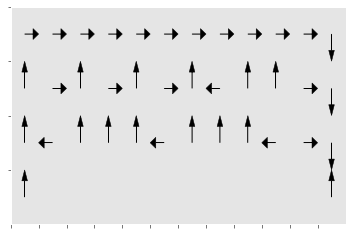

In [16]:
import matplotlib.pyplot as plt
import numpy as np
action = ["up", "right", "down", "left"]

# get greedy policy from Q
policy = np.array([np.argmax(Q[key]) if key in Q else -1 for key in np.arange(48)])
print("Reshaped Grid Policy:")
actions = np.stack([action for _ in range(len(policy))], axis=0)
policy = np.reshape(policy, (4, 12))


# Map policy values to directions
# Note: Assuming 0=UP, 1=RIGHT, 2=DOWN, 3=LEFT, -1=no action
directions = {
    0: (0, -1),
    1: (1, 0),
    2: (0, 1),
    3: (-1, 0),
    -1: (0, 0)  # No movement for -1
}

fig, ax = plt.subplots()

# Size of the grid
nrows, ncols = policy.shape

# Create a grid of points
ax.set_xlim(0, ncols)
ax.set_ylim(0, nrows)
plt.gca().invert_yaxis()  # Invert y axis to have the first row at the top

# Plot arrows for each policy direction
for y in range(nrows):
    for x in range(ncols):
        dx, dy = directions[policy[y, x]]
        if policy[y, x] != -1:  # If action is defined
            ax.arrow(x + 0.5, y + 0.5, dx * 0.3, dy * 0.3, head_width=0.2, head_length=0.2, fc='k', ec='k')

# Additional settings for clarity
ax.set_xticks(np.arange(0, ncols, 1))
ax.set_yticks(np.arange(0, nrows, 1))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(which='both')

plt.show()
